## Imports

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

## Dataset Exploration

In [2]:
dataset = ImageFolder('../input/stanford-dogs-dataset/images/Images')

In [3]:
len(dataset)

20580

In [4]:
len(dataset.classes)

120

In [5]:
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.classes:
    breeds.append(rename(n))

## Creating training, validation and testing dataset

In [6]:
random_seed = 45
torch.manual_seed(random_seed);

In [7]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(12966, 1440, 6174)

In [8]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(12966, 1440, 6174)

n02107908-Appenzeller
<class 'PIL.Image.Image'>


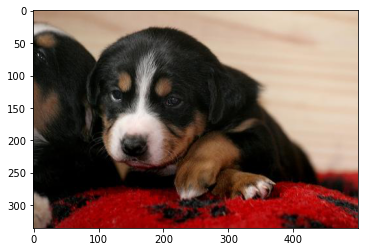

In [9]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

## Creating Custom Dataset

To create our custom Dataset, we need to extend Pytorch's `Dataset` class.
We need to implement 3 methods inside our Custom Dataset Class:

1. `__init__`
2. `__len__`
3. `__getitem__`

In [10]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [11]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

In [12]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

Lets quickly take a look into our training dataset

89


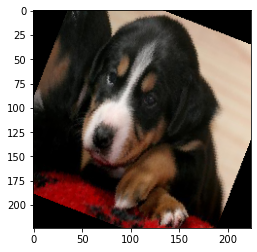

In [13]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

Now we will create Training , validation data and test data loader 

In [14]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

We can also take a peek into our dataset by creating grid of images using Pytorch's `make_grid()` method.

In [15]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

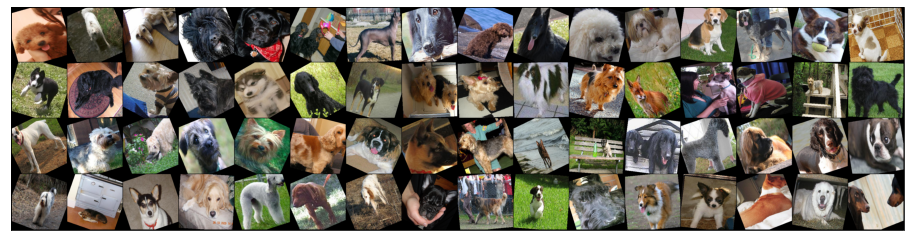

In [16]:
show_batch(train_dl)

## Network Architecture

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [18]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        

In [19]:
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),   # 224 * 244 * 32
            nn.ReLU(),                                   
            nn.Conv2d(32, 32, 3, stride=1, padding=1),       
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 112 * 112 * 32
            
            nn.Conv2d(32, 64, 3, stride=1, padding=1),   # 112 * 112* 64
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, stride=1, padding=1),    # 112 * 112* 128
            nn.ReLU(),
            nn.MaxPool2d(2,2),                          # 56 * 56* 128
            
            nn.Conv2d(128, 256, 3, stride=1, padding=1),   # 56*56*256
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),  # 56*56*256
            nn.ReLU(), 
            nn.MaxPool2d(2,2),                        # 28*28*256
            
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # 14*14*256
            
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # 7*7*256
            
            nn.Flatten(),
            nn.Linear(7*7*256, 512),
            nn.ReLU(),
            nn.Linear(512, 120),
            nn.LogSoftmax(dim = 1),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [20]:
model = DogBreedClassificationCNN()
model

DogBreedClassificationCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): MaxPool2d(kernel_size=2, stride=2, p

Let's define ResNet-34 Pre-trained model

In [21]:
class DogBreedPretrainedResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [22]:
model2 = DogBreedPretrainedResnet34()
model2

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


DogBreedPretrainedResnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

### Let's now use some more pre-trained models

Inception V3

In [23]:
class DogBreedPretrainedInceptionV3(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.inception_v3(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [24]:
# model3 = DogBreedPretrainedInceptionV3()
# model3

Resnet 152

In [25]:
class DogBreedPretrainedResnet152(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet152(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [26]:
model4 = DogBreedPretrainedResnet152()
model4

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


DogBreedPretrainedResnet152(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

VGG16

In [27]:
class DogBreedPretrainedVGG16(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.vgg16(pretrained=True)
        # Replace last layer  
        self.network.classifier = nn.Sequential(
           nn.Linear(in_features=25088, out_features=4096, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.5, inplace=False),
           nn.Linear(in_features=4096, out_features=4096, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.5, inplace=False),
           nn.Linear(in_features=4096, out_features=120, bias=True),
           nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [28]:
model5 = DogBreedPretrainedVGG16()
model5

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


DogBreedPretrainedVGG16(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

GoogleNet

In [29]:
class DogBreedPretrainedGoogleNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.googlenet(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [30]:
model6 = DogBreedPretrainedGoogleNet()
model6

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth


DogBreedPretrainedGoogleNet(
  (network): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=Fa

DenseNet

In [31]:
class DogBreedPretrainedDenseNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.densenet161(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [32]:
model7 = DogBreedPretrainedDenseNet()
model7

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth


DogBreedPretrainedDenseNet(
  (network): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps

Wide ResNet-50-2

In [33]:
class DogBreedPretrainedWideResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.wide_resnet50_2(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [34]:
model1 = DogBreedPretrainedWideResnet()
model1

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/checkpoints/wide_resnet50_2-95faca4d.pth


DogBreedPretrainedWideResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsamp

## Moving Data to GPU

In [35]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [36]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [37]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


# moving model to gpu
to_device(model1, device);

cuda


## Training 

In [38]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model1(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_dl)

images shape :  torch.Size([64, 3, 224, 224])
labels :  tensor([ 10,  13,  39,  74,  25,  37,  19,  94,   8,  81,  41,  25, 119,  69,
         20,  93,  38,  79,  12,  41,  80, 109,  34,  75, 106,  27,  36, 104,
         96,  67,  10,   8,  82,  37,  41,  98,  64,  94,  43,  31,  33,  40,
         52,  78,  51,  61,  52,  49,  35,  79,  26,  67,  86,  60, 108,  17,
         97,  33, 118,   6, 112,  48,  45,  50], device='cuda:0')
outs.shape : torch.Size([64, 120])
outs :  tensor([[-4.9312, -4.3020, -4.5556,  ..., -5.4221, -5.0174, -4.6488],
        [-4.8387, -4.1993, -4.3856,  ..., -5.2695, -4.9661, -4.8956],
        [-4.6853, -4.5049, -4.6636,  ..., -4.7697, -4.8715, -5.0130],
        ...,
        [-4.7010, -4.1909, -4.4912,  ..., -5.1355, -4.9156, -4.9501],
        [-4.6036, -3.9401, -4.2963,  ..., -5.1530, -5.3555, -4.2775],
        [-4.6263, -4.2706, -4.5639,  ..., -4.9061, -4.8298, -4.6809]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)


Now we'll train the model

In [39]:
from tqdm.notebook import tqdm

In [40]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [41]:
evaluate(model1, val_dl)                 # change model object here

{'val_loss': 4.855583190917969, 'val_acc': 0.008463541977107525}

In [42]:
# set hyperparams
num_epochs = 5
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [43]:
history = fit_one_cycle(num_epochs, max_lr, model1, train_dl, val_dl, weight_decay, grad_clip, opt_func)


Epoch [0] : train_loss: 2.8206, val_loss: 1.0798, val_acc: 0.7018



Epoch [1] : train_loss: 0.7657, val_loss: 0.8967, val_acc: 0.7266



Epoch [2] : train_loss: 0.5316, val_loss: 0.8514, val_acc: 0.7539



Epoch [3] : train_loss: 0.3150, val_loss: 0.5567, val_acc: 0.8262



Epoch [4] : train_loss: 0.1704, val_loss: 0.4822, val_acc: 0.8464


In [44]:
num_epochs = 3
max_lr = 0.001
history += fit_one_cycle(num_epochs, max_lr, model1, train_dl, val_dl, weight_decay, grad_clip, opt_func)


Epoch [0] : train_loss: 0.1403, val_loss: 0.4960, val_acc: 0.8418



Epoch [1] : train_loss: 0.1286, val_loss: 0.4899, val_acc: 0.8451



Epoch [2] : train_loss: 0.1178, val_loss: 0.4918, val_acc: 0.8529


In [45]:
num_epochs = 2
max_lr = 0.0001
history += fit_one_cycle(num_epochs, max_lr, model1, train_dl, val_dl, weight_decay, grad_clip, opt_func)


Epoch [0] : train_loss: 0.1153, val_loss: 0.4844, val_acc: 0.8464



Epoch [1] : train_loss: 0.1110, val_loss: 0.4817, val_acc: 0.8477


## Plotting history

In [46]:
history[0].keys()

dict_keys(['val_loss', 'val_acc', 'train_loss', 'lrs'])

In [47]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

### Loss v/s Epochs plot

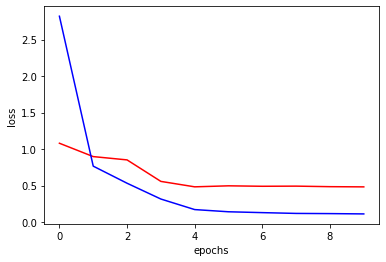

In [48]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### Accuracy v/s Epochs plot

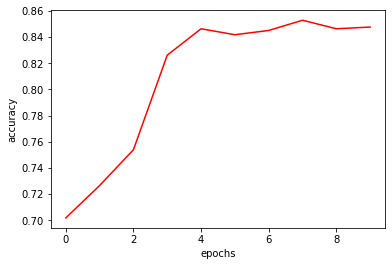

In [49]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

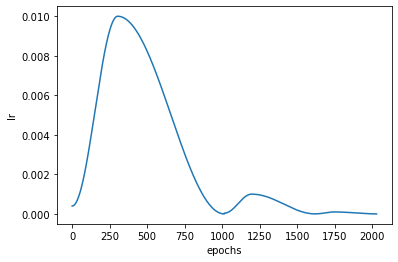

In [50]:
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.xlabel('epochs')
plt.ylabel('lr')
plt.plot(lrs)
plt.show()

## Prediction

In [51]:
def predict_single(img, label):
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = model1(xb)                   # change model object here
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', breeds[label], ' | Predicted :', breeds[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()

Actual : African hunting dog  | Predicted : African hunting dog


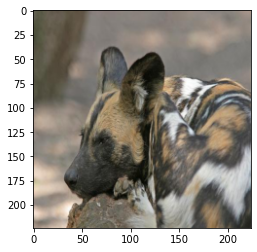

In [52]:
predict_single(*test_dataset[6])

Actual : Scottish deerhound  | Predicted : Scottish deerhound


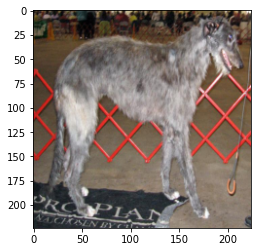

In [53]:
predict_single(*test_dataset[1])

Actual : Italian greyhound  | Predicted : Italian greyhound


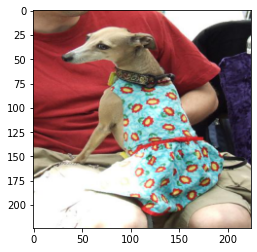

In [54]:
predict_single(*test_dataset[93])

In [55]:
test_dl = DeviceDataLoader(test_dl, device)

In [56]:
result = evaluate(model1, test_dl)
result

{'val_loss': 0.45727336406707764, 'val_acc': 0.8556122183799744}

## Save model

In [57]:
weights_fname = 'dog-breed-classifier-wideresnet_with_data_aug.pth'
torch.save(model4.state_dict(), weights_fname)

## Commit to Jovian

In [58]:
!pip install jovian --upgrade --quiet

In [59]:
import jovian

<IPython.core.display.Javascript object>

In [60]:
jovian.reset()
jovian.log_hyperparams(arch='wideresnet_with_data_aug', 
                       epochs=len(history), 
                       max_lr_01=0.01,
                       max_lr_02=0.001,
                       max_lr_03=0.0001,
                       scheduler='one-cycle', 
                       batch_size = batch_size,
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Hyperparams logged.


In [61]:
jovian.log_metrics(
    train_loss=history[-1]['train_loss'],
    val_loss=history[-1]['val_loss'], 
    val_score=history[-1]['val_acc'],
    test_score=result['val_acc'],
    test_loss=result['val_loss']
)

[jovian] Metrics logged.


In [62]:
project_name='dog-breed-classifier-final'

In [63]:
jovian.commit(project=project_name, environment=None, outputs=[weights_fname])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/ankitvashisht12/dog-breed-classifier-final


<IPython.core.display.Javascript object>